# Introduction

> Use the `keras` from Tensorflow to build ANN model that would fit the credit score data and be able to generalize well.

Use the Credit Score Classification dataset provided [here](https://www.kaggle.com/datasets/parisrohan/credit-score-classification) to train and test your design.

**Notes:**
- Split the data as you see fit and use validation during training.
- You may re-use the EDA, data preparation, and other sections you previously used in ML1 assignemnts.
- Remember that you can use classification metrics from other libraries as well (e.g., `sklearn`)
- Plot the loss, and accuracy against epochs and extract insights on how well of a fit your model is.
- This time the notebook is not prepared with sections and instructions so that you can do it yourself.
- If you are stuck, you can consult the [Keras User Guide](https://keras.io/api/). There are some useful [Code Examples](https://keras.io/examples/) as well.


# `01` Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from keras.utils import set_random_seed
import regex as re
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder,RobustScaler
from sklearn.impute import KNNImputer

----------------
## Global variables

In [2]:
SEED = 1234
EPOCHS = 200
BATCH_SIZE = 150

In [3]:
## constant seed for the same result
set_random_seed(SEED)

------------
# `02` Load Data



In [4]:
data = pd.read_csv("/content/train.csv")
data.shape

(100000, 28)

In [5]:
data.head(2)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.82262,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.94496,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good


In [6]:
## drop unnecessary columns
X = data.drop(['Credit_Score','ID','Customer_ID','Name','SSN','Type_of_Loan'], axis=1)
y = data['Credit_Score']
X.shape, y.shape

((100000, 22), (100000,))

----------------

# `ii`Split data

>* 8% for testset and 15% for validset



In [7]:
## split the test set, train set and validation set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.08, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1/0.92,random_state=SEED)

X_train.shape ,X_test.shape,X_val.shape, y_train.shape, y_test.shape ,y_val.shape

((82000, 22), (8000, 22), (10000, 22), (82000,), (8000,), (10000,))

----------------

# `03` Exploratory Data Analysis (EDA)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82000 entries, 55303 to 73099
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     82000 non-null  object 
 1   Age                       82000 non-null  object 
 2   Occupation                82000 non-null  object 
 3   Annual_Income             82000 non-null  object 
 4   Monthly_Inhand_Salary     69679 non-null  float64
 5   Num_Bank_Accounts         82000 non-null  int64  
 6   Num_Credit_Card           82000 non-null  int64  
 7   Interest_Rate             82000 non-null  int64  
 8   Num_of_Loan               82000 non-null  object 
 9   Delay_from_due_date       82000 non-null  int64  
 10  Num_of_Delayed_Payment    76205 non-null  object 
 11  Changed_Credit_Limit      82000 non-null  object 
 12  Num_Credit_Inquiries      80395 non-null  float64
 13  Credit_Mix                82000 non-null  object 
 14  Outstan

In [9]:
X_train.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,69679.000000,4198.711031,3187.079813,303.645417,1626.594167,3096.836667,5961.745000,15204.633333
Num_Bank_Accounts,82000.000000,17.227793,118.209444,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,82000.000000,22.519098,129.265925,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,82000.000000,72.495488,466.150726,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,82000.000000,21.074878,14.862024,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,80395.000000,28.133752,195.494423,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,82000.000000,32.284615,5.121018,20.100770,28.042989,32.316003,36.502720,50.000000
Total_EMI_per_month,82000.000000,1410.536435,8322.978256,0.000000,30.133133,69.266164,161.747685,82256.000000


In [10]:
## check nulls
missing = pd.DataFrame(
    {
        'missing': X_train.isnull().sum(),
        'missing percentage': (X_train.isnull().sum()/len(X_train))*100
    }

)
missing.style.background_gradient(cmap='Blues')

,missing,missing percentage
Month,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
Annual_Income,0,0.000000
Monthly_Inhand_Salary,12321,15.025610
Num_Bank_Accounts,0,0.000000
Num_Credit_Card,0,0.000000
Interest_Rate,0,0.000000
Num_of_Loan,0,0.000000
Delay_from_due_date,0,0.000000


In [11]:
## check outliers
### detect outliers

num_feat = X_train.select_dtypes('number')

Q1 = num_feat.quantile(0.25)
Q3 = num_feat.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (num_feat < lower_bound) | (num_feat > upper_bound)

outlier_counts = outliers_mask.sum(axis=0)

total_rows = num_feat.shape[0]
outlier_percentage = (outlier_counts / total_rows) * 100

outliers_summary = pd.DataFrame({
    "Number of Outliers": outlier_counts,
    "Outlier Percentage": outlier_percentage
})

outliers_summary.style.background_gradient(cmap='Blues')


,Number of Outliers,Outlier Percentage
Monthly_Inhand_Salary,1369,1.669512
Num_Bank_Accounts,1087,1.325610
Num_Credit_Card,1859,2.267073
Interest_Rate,1670,2.036585
Delay_from_due_date,3295,4.018293
Num_Credit_Inquiries,1367,1.667073
Credit_Utilization_Ratio,4,0.004878
Total_EMI_per_month,5596,6.824390


In [12]:
X_train.describe(include="object").T.style.background_gradient(cmap='Oranges')

,count,unique,top,freq
Month,82000,8,June,10324
Age,82000,1529,38,2361
Occupation,82000,16,_______,5792
Annual_Income,82000,18000,17273.83,15
Num_of_Loan,82000,375,3,11781
Num_of_Delayed_Payment,76205,640,19,4381
Changed_Credit_Limit,82000,4252,_,1704
Credit_Mix,82000,4,Standard,29957
Outstanding_Debt,82000,13022,1360.45,24
Credit_History_Age,74628,404,15 Years and 9 Months,373


------------------------------------
## `ii` Visual Analysis

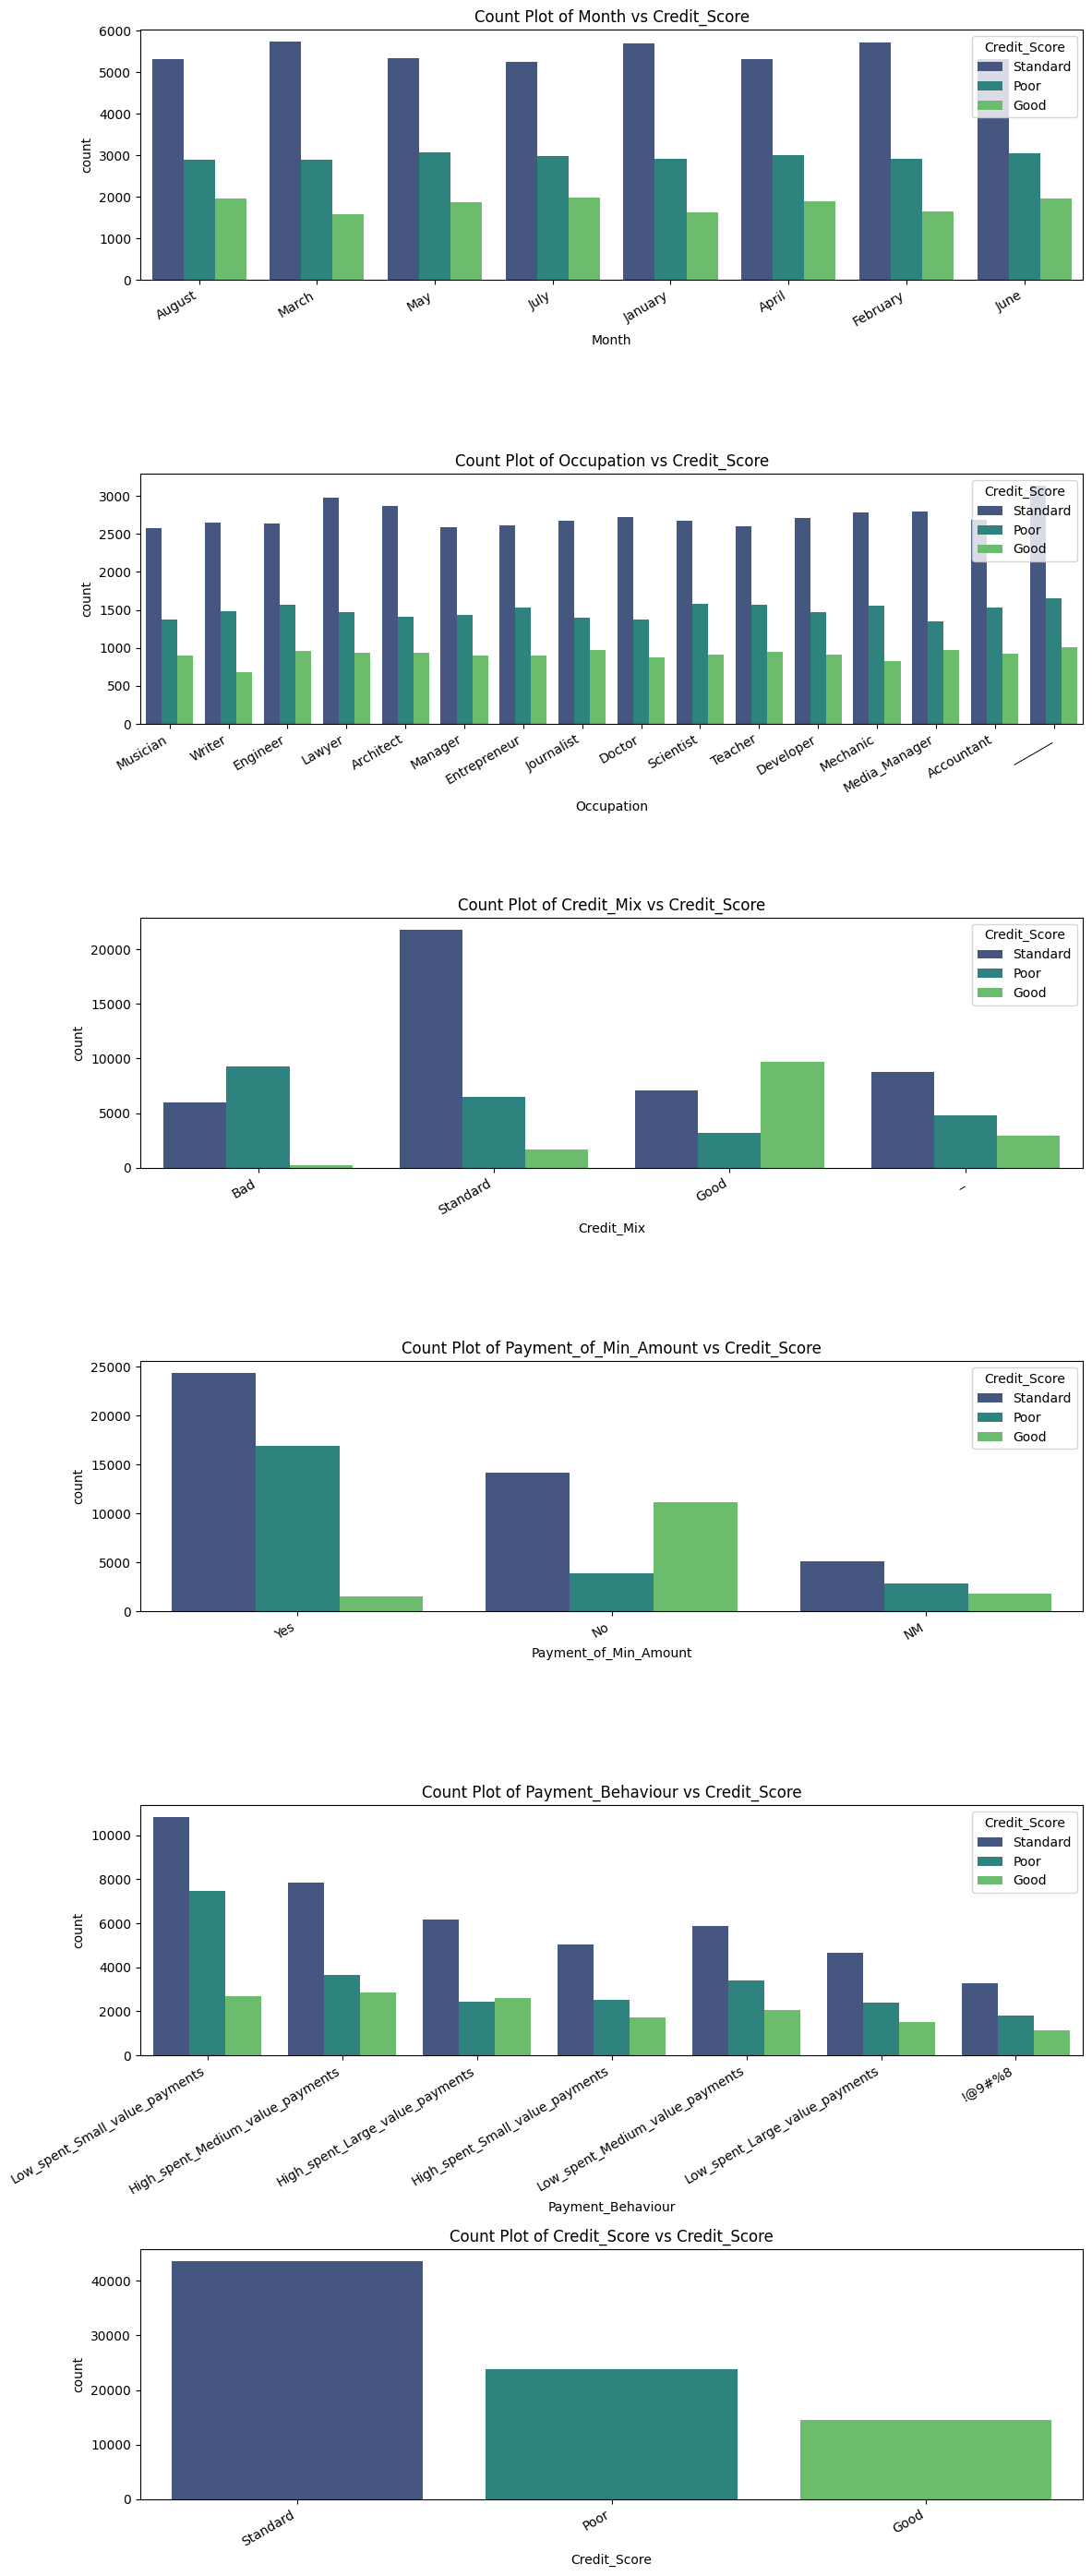

In [13]:
#### ploting count plot for categorical features
object_feats = X_train.select_dtypes('object').columns
columns_list = ['Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
target = 'Credit_Score'
plt.figure(figsize=(12, len(object_feats) * 2))
x_train_ = X_train.copy()
x_train_[target] = y_train

for i, col in enumerate(columns_list, 1):
    plt.subplot(len(columns_list), 1, i)
    sns.countplot(data=x_train_, x=col, hue=target, palette='viridis')
    plt.title(f"Count Plot of {col} vs {target}")
    plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

----------------

# `04` Data Preparation

# `i` Handling columns

In [14]:
##Calculate the month from the entire string and convert it to months using regex
def convert_age_to_months(history_age):
    if pd.notna(history_age):  # NaN checking
        match = re.match(r"(\d+) Years\s*and\s*(\d+) Months", history_age)
        if match:
            years = int(match.group(1))
            months = int(match.group(2))
            total_months = years * 12 + months
            return total_months
    return np.nan  #Return NaN if there is no match or if it is NaN

#Apply the function to the column
X_train['Credit_History_Age'] = X_train['Credit_History_Age'].apply(convert_age_to_months)

In [15]:
## categorical columns which need encoding after hadling rubbish values
## make wrong values = nan ,for Occupation column
def prepration(X_train):
    X_train["Occupation"].loc[X_train["Occupation"] == "_______"] = pd.NA


    ## make wrong values = nan , for Credit_Mix column
    X_train["Credit_Mix"].loc[X_train["Credit_Mix"] == "_"] = pd.NA


    ## make wrong values = nan , for Payment_of_Min_Amount column
    X_train["Payment_of_Min_Amount"].loc[X_train["Payment_of_Min_Amount"] == "NM"] = pd.NA


    ## make wrong values = nan , for Payment_Behaviour column
    X_train["Payment_Behaviour"].loc[X_train["Payment_Behaviour"] == "!@9#%8"] = pd.NA


    ## handling Age column
    X_train['Age'] = X_train['Age'].str.replace('_', '').astype(np.float16)
    ## removing outliers of Age column
    X_train['Age'].loc[X_train['Age'] > 100] = np.nan

    ## try to handle outliers of Num_Credit_Card column
    X_train['Num_Credit_Card'].loc[X_train['Num_Credit_Card'] > 100] = np.nan

    ## remove negative values of this column
    X_train['Num_Bank_Accounts'].loc[X_train['Num_Bank_Accounts'] < 0] = 0

    ## handling Annual_Income column
    X_train['Annual_Income'] = X_train['Annual_Income'].str.replace('_', '').astype(np.float16)

    ## handling Num_of_Loan column
    X_train['Num_of_Loan'] = X_train['Num_of_Loan'].str.replace('_', '').astype(np.float16)


    ## handling Num_of_Delayed_Payment column
    X_train['Num_of_Delayed_Payment'] = X_train['Num_of_Delayed_Payment'].str.replace('_', '').astype(np.float16)


    ## handling  Amount_invested_monthly column
    X_train['Amount_invested_monthly'] = X_train['Amount_invested_monthly'].str.replace('_', '').astype(np.float16)


    ## handling Monthly_Balance column
    X_train['Monthly_Balance'] = X_train['Monthly_Balance'].str.replace('_', '').astype(np.float16)


    ## handling  Changed_Credit_Limit column
    X_train['Changed_Credit_Limit'] = (X_train['Changed_Credit_Limit'].str.replace('_', '').replace('', np.nan).astype(np.float16))


    ## convert Outstanding_Debt column to float
    X_train['Outstanding_Debt'] = X_train['Outstanding_Debt'].str.replace('_', '').astype(np.float16)


prepration(X_train)

#### Handling Null values

In [16]:
### encoding categorical columns

def encoding(X_train):
        # Dictionary to store encoders
        encoders = dict()

        # Select categorical features
        categorical_features = X_train.select_dtypes('object')

        # Define ordered categories for ordinal encoding
        month_order = [['January', 'February', 'March', 'April', 'May', 'June', 'July',
                        'August', 'September', 'October', 'November', 'December']]


        credit_mix_order = [['Bad', 'Standard', 'Good']]

        for col_name in categorical_features.columns:
            series = X_train[col_name]

            # Replace NaNs with "Unknown" before encoding
            temp_series = series.fillna("Unknown")

            if col_name == 'Month':  # Apply Ordinal Encoding for months
                encoder = OrdinalEncoder(categories=month_order, handle_unknown="use_encoded_value", unknown_value=-1)
                X_train[col_name] = encoder.fit_transform(temp_series.to_frame())[:, 0]  # Convert to 1D

            elif col_name == 'Credit_Mix':  # Apply Ordinal Encoding for Credit Mix
                encoder = OrdinalEncoder(categories=credit_mix_order, handle_unknown="use_encoded_value", unknown_value=-1)
                X_train[col_name] = encoder.fit_transform(temp_series.to_frame())[:, 0]

            elif col_name == 'Payment_of_Min_Amount':  # Apply Label Encoding (Binary)
                encoder = LabelEncoder()
                X_train[col_name] = encoder.fit_transform(temp_series)

            elif col_name in ['Occupation', 'Payment_Behaviour']:  # Apply Label Encoding instead of One-Hot
                encoder = LabelEncoder()
                X_train[col_name] = encoder.fit_transform(temp_series)

            #Restore original NaNs after encoding
            X_train[col_name] = X_train[col_name].replace(
                encoder.transform(np.array(["Unknown"]).reshape(-1, 1) if isinstance(encoder, OrdinalEncoder) else np.array(["Unknown"])),
                np.nan
            )

            # Store encoder for later use on test set
            encoders[col_name] = encoder
        return encoders


encoders = encoding(X_train)


In [17]:
# Select numerical columns except 'Month'
cols = X_train.select_dtypes(include=np.number).drop('Month', axis=1)

# Replace infinite values with NaN
X_train[cols.columns] = X_train[cols.columns].replace([np.inf, -np.inf], np.nan)

# Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
X_train_imputed = knn_imputer.fit_transform(X_train[cols.columns])

# Convert back to DataFrame
X_train[cols.columns] = pd.DataFrame(X_train_imputed, columns=cols.columns, index=X_train.index)

X_train.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
55303,7.0,20.0,11.0,14840.0,1501.708333,9.0,8.0,25.0,9.0,11.0,...,7.0,0.0,2686.0,27.710282,147.0,2.0,84.420843,191.2500,5.0,164.50
46946,2.0,21.0,15.0,60416.0,5163.450000,6.0,6.0,27.0,6.0,45.0,...,11.0,0.0,2254.0,27.535706,139.6,2.0,226.896339,98.7500,1.0,440.75
36500,4.0,28.0,4.0,43520.0,3567.572500,8.0,7.0,7.0,6.0,29.0,...,5.0,1.0,1285.0,38.812549,101.0,2.0,183.183267,64.1250,0.0,349.50
67932,4.0,30.0,7.0,38720.0,3187.964167,2.0,4.0,3.0,2.0,15.0,...,2.0,2.0,801.0,35.320645,206.0,0.0,43.943751,122.5000,1.0,402.25
48474,2.0,25.0,11.0,33088.0,2989.463333,6.0,10.0,29.0,6.0,16.0,...,7.0,0.0,1507.0,32.357558,147.0,2.0,85.504788,74.4375,1.0,389.00


In [18]:
missing = pd.DataFrame(
    {
        'missing': X_train.isnull().sum(),
        'missing percentage': (X_train.isnull().sum()/len(X_train))*100
    }

)

missing.style.background_gradient(cmap='Oranges')

,missing,missing percentage
Month,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
Annual_Income,0,0.000000
Monthly_Inhand_Salary,0,0.000000
Num_Bank_Accounts,0,0.000000
Num_Credit_Card,0,0.000000
Interest_Rate,0,0.000000
Num_of_Loan,0,0.000000
Delay_from_due_date,0,0.000000


In [19]:
#### apply scaling
scaler = RobustScaler()

# Select only numerical features
numerical_features = X_train.select_dtypes(include=['float64', 'int64','float16'])

# Fit on training data & transform both train and test sets
X_train[numerical_features.columns] = scaler.fit_transform(X_train[numerical_features.columns])



In [20]:
### encoding y_train

encoder_y = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])
y_train = encoder_y.fit_transform(y_train.values.reshape(-1, 1))


In [21]:
np.isnan(y_train).sum()

np.int64(0)

## `#` Prepare validaion Set Test Set

Apply the data transformations you used on the training set to the test set.


In [22]:
### valid set, test set -->column Credit_History_Age
X_val['Credit_History_Age'] = X_val['Credit_History_Age'].apply(convert_age_to_months)
X_test['Credit_History_Age'] = X_test['Credit_History_Age'].apply(convert_age_to_months)

## apply all cleaning for the data
prepration(X_val)
prepration(X_test)

In [23]:
encoders.items()

dict_items([('Month', OrdinalEncoder(categories=[['January', 'February', 'March', 'April', 'May',
                            'June', 'July', 'August', 'September', 'October',
                            'November', 'December']],
               handle_unknown='use_encoded_value', unknown_value=-1)), ('Occupation', LabelEncoder()), ('Credit_Mix', OrdinalEncoder(categories=[['Bad', 'Standard', 'Good']],
               handle_unknown='use_encoded_value', unknown_value=-1)), ('Payment_of_Min_Amount', LabelEncoder()), ('Payment_Behaviour', LabelEncoder())])

In [24]:
label_occ = encoders['Occupation']
X_test['Occupation'] = X_test['Occupation'].fillna('Unknown')
X_test['Occupation'] = label_occ.transform(X_test['Occupation'])


X_test['Occupation'] = X_test['Occupation'].replace(
                label_occ.transform(np.array(["Unknown"]).reshape(-1, 1) if isinstance(label_occ, OrdinalEncoder) else np.array(["Unknown"])),
                np.nan
            )


X_val['Occupation'] = X_val['Occupation'].fillna('Unknown')
X_val['Occupation'] = label_occ.transform(X_val['Occupation'])


X_val['Occupation'] = X_val['Occupation'].replace(
                label_occ.transform(np.array(["Unknown"]).reshape(-1, 1) if isinstance(label_occ, OrdinalEncoder) else np.array(["Unknown"])),
                np.nan
            )

In [25]:
# Retrieve the saved OrdinalEncoder for 'Month'
label_Month = encoders['Month']
# Apply the OrdinalEncoder transformation correctly
X_test['Month'] = label_Month.transform(X_test[['Month']])  # Keep it as DataFrame
X_val['Month'] = label_Month.transform(X_val[['Month']])

In [26]:
# Retrieve the saved Encoder for 'Credit_Mix'
label_Mix = encoders['Credit_Mix']
# Apply the OrdinalEncoder transformation correctly
X_test['Credit_Mix'] = label_Mix.transform(X_test[['Credit_Mix']])
X_val['Credit_Mix'] = label_Mix.transform(X_val[['Credit_Mix']])


In [27]:
# Retrieve the saved LabelEncoder for 'Payment_of_Min_Amount'
label_Amount = encoders['Payment_of_Min_Amount']

# Convert to string to avoid NA-related issues
X_test['Payment_of_Min_Amount'] = X_test['Payment_of_Min_Amount'].astype(str)
X_val['Payment_of_Min_Amount'] = X_val['Payment_of_Min_Amount'].astype(str)

# Ensure only known categories are encoded, setting unknown ones to NaN
known_classes = set(label_Amount.classes_)

X_test['Payment_of_Min_Amount'] = X_test['Payment_of_Min_Amount'].apply(
    lambda x: label_Amount.transform([x])[0] if x in known_classes else np.nan
)
X_val['Payment_of_Min_Amount'] = X_val['Payment_of_Min_Amount'].apply(
    lambda x: label_Amount.transform([x])[0] if x in known_classes else np.nan
)


In [28]:
# Retrieve the saved Encoder for 'Payment_Behaviour'
label_Payment = encoders['Payment_Behaviour']

# Convert to string to avoid NA-related issues
X_test['Payment_Behaviour'] = X_test['Payment_Behaviour'].astype(str)
X_val['Payment_Behaviour'] = X_val['Payment_Behaviour'].astype(str)

# Ensure only known categories are encoded, setting unknown ones to NaN
known_classes = set(label_Payment.classes_)

X_test['Payment_Behaviour'] = X_test['Payment_Behaviour'].apply(
    lambda x: label_Payment.transform([x])[0] if x in known_classes else np.nan
)
X_val['Payment_Behaviour'] = X_val['Payment_Behaviour'].apply(
    lambda x: label_Payment.transform([x])[0] if x in known_classes else np.nan)

In [29]:
X_test = X_test.reindex(columns=X_train.columns)
X_val = X_val.reindex(columns=X_train.columns)


In [30]:
# Ensure 'Month' is excluded before applying KNN Imputation
numerical_features_val = X_val.select_dtypes(include=np.number).drop(columns=['Month'], errors='ignore')
numerical_features_test = X_test.select_dtypes(include=np.number).drop(columns=['Month'], errors='ignore')

# Replace infinite values with NaN to avoid errors
numerical_features_val = numerical_features_val.replace([np.inf, -np.inf], np.nan)
numerical_features_test = numerical_features_test.replace([np.inf, -np.inf], np.nan)

# Apply KNN Imputer
X_val[numerical_features_val.columns] = knn_imputer.transform(numerical_features_val)
X_test[numerical_features_test.columns] = knn_imputer.transform(numerical_features_test)

# Apply Scaling
numerical_features_val = X_val.select_dtypes(include=['float64', 'int64', 'float16'])
numerical_features_test = X_test.select_dtypes(include=['float64', 'int64', 'float16'])

X_val[numerical_features_val.columns] = scaler.transform(numerical_features_val)
X_test[numerical_features_test.columns] = scaler.transform(numerical_features_test)


In [31]:
missing = pd.DataFrame(
    {
        'missing_test': X_test.isnull().sum(),
        'missing percentage_test': (X_test.isnull().sum()/len(X_test))*100,
        'missing_val': X_val.isnull().sum(),
        'missing percentage_val': (X_val.isnull().sum()/len(X_val))*100
    }

)

missing.style.background_gradient(cmap='Oranges')

,missing_test,missing percentage_test,missing_val,missing percentage_val
Month,0,0.000000,0,0.000000
Age,0,0.000000,0,0.000000
Occupation,0,0.000000,0,0.000000
Annual_Income,0,0.000000,0,0.000000
Monthly_Inhand_Salary,0,0.000000,0,0.000000
Num_Bank_Accounts,0,0.000000,0,0.000000
Num_Credit_Card,0,0.000000,0,0.000000
Interest_Rate,0,0.000000,0,0.000000
Num_of_Loan,0,0.000000,0,0.000000
Delay_from_due_date,0,0.000000,0,0.000000


In [32]:
y_test = encoder_y.transform(y_test.values.reshape(-1, 1))
y_val = encoder_y.transform(y_val.values.reshape(-1, 1))

In [33]:
np.isnan(y_test).sum(),np.isnan(y_val).sum()

(np.int64(0), np.int64(0))

In [34]:
# Apply one-hot encoding to the target variable

y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

----------------------

# `05` Apply Model (ANN)


In [52]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy','Precision'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │             736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,315 (5.14 KB)

 Trainable params: 1,315 (5.14 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
hist = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=[X_val, y_val])

Epoch 1/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - Precision: 0.5339 - accuracy: 0.5061 - loss: 1.6506 - val_Precision: 0.6510 - val_accuracy: 0.6221 - val_loss: 0.8638
Epoch 2/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.6743 - accuracy: 0.6370 - loss: 0.7915 - val_Precision: 0.6760 - val_accuracy: 0.6449 - val_loss: 0.8915
Epoch 3/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.6973 - accuracy: 0.6533 - loss: 0.7587 - val_Precision: 0.6833 - val_accuracy: 0.6504 - val_loss: 0.9031
Epoch 4/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - Precision: 0.7076 - accuracy: 0.6629 - loss: 0.7485 - val_Precision: 0.6798 - val_accuracy: 0.6458 - val_loss: 0.9102
Epoch 5/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - Precision: 0.7108 - accuracy: 0.6668 - loss: 0.7366 - val_Precision: 0.6864 - val_accuracy: 0.6521 - val_loss: 0.8807
Epoch 6/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - Precision: 0.7150 - accuracy: 0.6695 - loss: 0.7295 - val_Precision: 0.6854 - v

In [37]:
hist.history.keys()

dict_keys(['Precision', 'accuracy', 'loss', 'val_Precision', 'val_accuracy', 'val_loss'])

In [54]:
eval = model.evaluate(X_val, y_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.7084 - accuracy: 0.6851 - loss: 0.8024


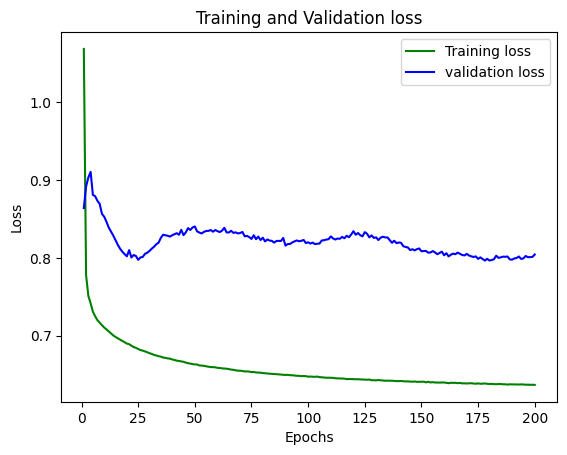

In [55]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

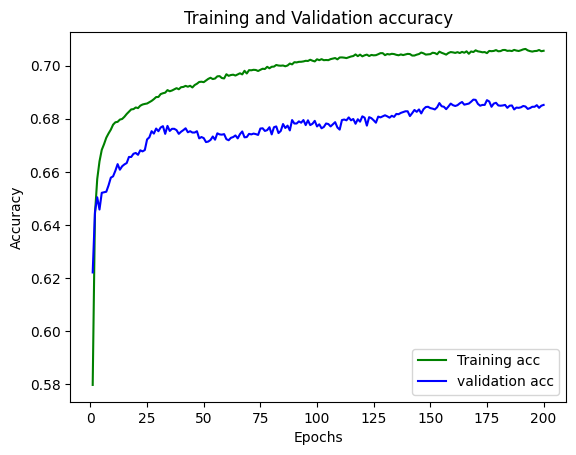

In [56]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(loss_train) + 1)

plt.scatter(x= EPOCHS,y= eval[1], c='r', label='evaluation Accuracy')
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [57]:
model.evaluate(X_test, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.7107 - accuracy: 0.6834 - loss: 0.7967


[0.8061357140541077, 0.6773750185966492, 0.7057510018348694]

------------

## Early stopping Model

In [58]:
### Model with early stoping
model2 = Sequential()
model2.add(Input(shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(3, activation='softmax'))
model2.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy','Precision'])

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 32)                  │             736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,315 (5.14 KB)

 Trainable params: 1,315 (5.14 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
early_stoping = EarlyStopping(monitor='accuracy', patience=15, restore_best_weights=True)

hist2 = model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=[X_val, y_val], callbacks=[early_stoping])

Epoch 1/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - Precision: 0.5542 - accuracy: 0.5487 - loss: 1.2433 - val_Precision: 0.6618 - val_accuracy: 0.6272 - val_loss: 0.8404
Epoch 2/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Precision: 0.6837 - accuracy: 0.6387 - loss: 0.7780 - val_Precision: 0.6785 - val_accuracy: 0.6363 - val_loss: 0.8529
Epoch 3/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7050 - accuracy: 0.6529 - loss: 0.7466 - val_Precision: 0.6864 - val_accuracy: 0.6445 - val_loss: 0.8413
Epoch 4/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.7147 - accuracy: 0.6607 - loss: 0.7321 - val_Precision: 0.6899 - val_accuracy: 0.6490 - val_loss: 0.8265
Epoch 5/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7169 - accuracy: 0.6635 - loss: 0.7251 - val_Precision: 0.6942 - val_accuracy: 0.6567 - val_loss: 0.8112
Epoch 6/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.7197 - accuracy: 0.6675 - loss: 0.7178 - val_Precision: 0.6945 - va

In [60]:
eval2 = model2.evaluate(X_val, y_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.6905 - accuracy: 0.6671 - loss: 0.9169


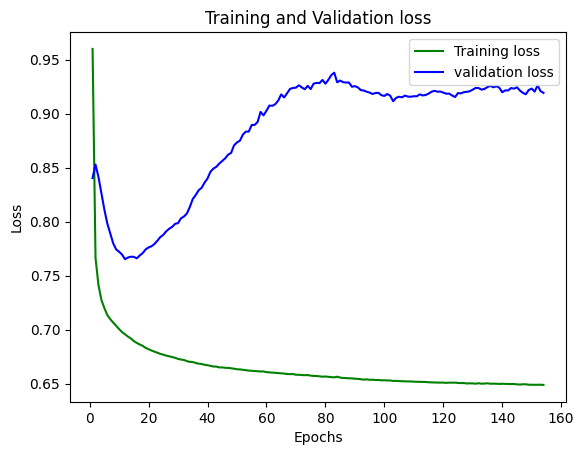

In [61]:
loss_train = hist2.history['loss']
loss_val = hist2.history['val_loss']
epochs = range(1, len(loss_train) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

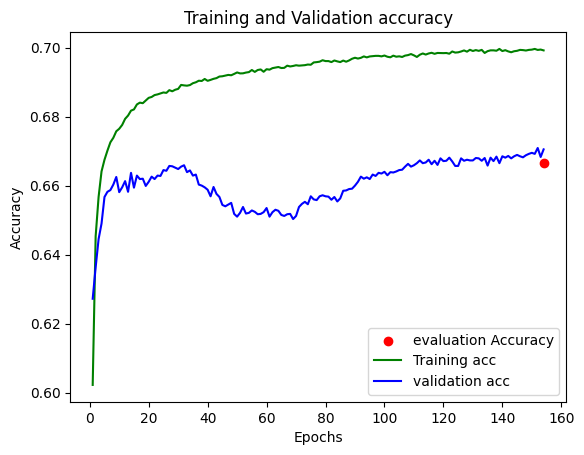

In [64]:
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']

plt.scatter(x= len(acc),y= eval2[1], c='r', label='evaluation Accuracy')

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();


#### my model has overfitting problem.....

In [63]:
model.evaluate(X_test, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.7107 - accuracy: 0.6834 - loss: 0.7967


[0.8061357140541077, 0.6773750185966492, 0.7057510018348694]

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$